## Before You Begin

To run simulations using this notebook, the following four files must be placed in the same folder:

1. This jupyter notebook
2. netgen.py (the network generator / the API)
3. BG_inh_pathway_spedup.c (the C simulator code)
4. rando2.h (header file for C code)

If you only wish to run experiments within the current scope of netgen.py (which are multi-alternative and stop-signal tasks), then you do not have to perform any actions outside of this notebook.  You are able to manipulate a wide range of variables for the experiment, including pathway efficacies, stimulus strengths/onset times, number of alternatives, etc.

Eventually I should make it easier to define new types of experiments / new neural populations from within the notebook, right now those are added to netgen.py.

For convenience, the API handles the compilation of the C code for you.  But for reference, the command to compile the C code is:

    gcc -o sim BG_inh_pathway_spedup.c rando2.h -lm -std=c99

which places the compiled code into a file named "sim".

## Imports

First, we import all of necessary modules:

In [42]:
# automatically apply changes in netgen
%load_ext autoreload
%autoreload 2

import random
 # allows performing command-line operations from within Python
from subprocess import call

# tell jupyter notebook to show plots inline (with output)
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats.distributions import norm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# tell whiny modules to shut up about it 
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", module="statsmodels")

# import the netgen
import netgen as ng

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set Working Directory

We must set the working directory of simulator, meaning the folder in which all simulation results will be placed.

This information (the current working directory) is lost whenever netgen.py is edited and re-imported, so you may run into errors while attempting API-related tasks.  The simple solution is to rerun this line of code.

In [77]:
ng.setDirectory("stopsignal001")

## Configure Experiments

Next, we use the `configureSweep` function to create a set of folders containing all of the desired combinations of simulation settings.

The `configureSweep` function takes a set of keyword arguments.  Any argument that is an array is treated as a possible "dimension" of the configuration space.  As of right now, it does an exhaustive search of the configuration space.  This will eventually change.

This function returns the number of unique configurations generated.

**Useful parameters regardless of experiment type:**

- `experiment` is the type of experiment to run.
  - `mc` means "multiple choice"
  - `ss` means "stop signal"
- `popscale` proportionally reduces the number of cell in each population (and adjusts connection strengths/connectivity accordingly) if you want to get similar results much faster than running a full simulation.  Speed is nice, and this simulation is O(n^2) so I like `popscale=0.5` when I'm debugging stuff.
- `preset` is a way of packaging parameters together in a way that an exhaustive search wouldn't.  You can set it to be an array of dictionaries, with each dictionary containing any set of parameters.  This `preset` array, as a whole, is treated as a *single* dimension in terms of the search space.  For example, the following code packages direct and indirect pathway strength together, so that only the combinations of weak-direct-strong-indirect and strong-direct-weak-indirect are performed, as opposed to doing an exhausive search (which would be 4 combinations).

    `preset=[{'direct':{'src':[0],'dest':[0],'mult':[.90]}, 'indirect':{'src':[0],'dest':[0],'mult':[1.10]}}, {'direct':{'src':[0],'dest':[0],'mult':[1.10]}, 'indirect':{'src':[0],'dest':[0],'mult'[.90]}}]`
    
**Experiment-specific parameters:**

Each of the following parameters has a default value which can be modified:

- `BaseStim` (2.0) the amount of stimulation to LIP before the experiment begins
- `WrongStim` (2.50) the amount of stimulation to the LIP areas for the incorrect option
- `RightStim` (2.54) the amount of stimulation represeting the correct option
- `Start` (300) number of milliseconds into the simulation where stimulus onset occurs
- `Choices` (default 2 for multi-alternative, 1 for stop signal) number of action channels, the first of which receives the "RightStim" and the rest of which receive the "WrongStim".
- `Dynamic` (30) Firing rate (in Hz) which the thalamus must reach to be interpreted as a decision (this serves as the dynamic cutoff).
- `CancelDelay` (200 for stop-signal) number of milliseconds after stimulus onset where the stop signal occurs.
- `CancelStim` (4.0 for stop-signal) stop-signal stimulus strength to the STNE.

**Parameters for adjusting pathways:**

The efficacy of any *named* pathway can be adjusted with parameters.  Right now the only named pathways (case-sensitive) in the basal ganglia model are:

- direct (D1STR -> GPi)
- indirect (D2STR -> GPe)
- arkypallidal (GPe -> FSI)
- CxSTR (M1/LIP -> STR)
- LIPsyn (LIP -> LIP)

Adding more names is really easy, however, and the configuration process for a particular experiment may also allow adjustment of other things.

There are two ways to adjust pathways: globally or 1-by-1.

Global adjustments are done using the format `direct=0.9` (or `'direct':0.9` if inside a `preset` dictionary), which adjusts all direct pathways in the network to be 90% of their normal efficacy.

1-by-1 adjustments are done using the format `direct={'src':[0,2],'dest':[1,3],'mult':[.9,1.1]}` which sets the connection from D1STR_0 to GPi_1 to 90% efficacy while also setting the connection from D1STR_2 to GPi_3 to 110% efficacy.

## Example Experiment Config

Here's the code to configure a straight-forward stop-signal experiment.  This sets `sweepcount` to `3` because that's the number of parameter combinations formed.

In [78]:
sweepcount = ng.configureSweep(experiment='ss', popscale=0.5, BaseStim=[2.45], direct=0.9, indirect=0.95,
                  WrongStim = [3.24], RightStim = [3.26], Dynamic=[30.0], STNExtFreq=[4.0],
                  CancelStim=[4,4.5], CancelDelay = 200, Choices=2, LIPsyn=[0.90], CxSTR=[0.55])
sweepcount

2

## Running Trials

Next we run all of the trials.  The function `compileAndRunSweep` takes three arguments:

- `trials` - the number of trials for each configuration to run
- `offset` - an offset on trial number, to allow adding more trials to an already-existing set of trials
- `sweepcount` - The number of configurations to run trials for, should generally be set equal to the output of `configureSweep()` to run every combination that was generated.

In [ ]:
ng.compileAndRunSweep(1,0,sweepcount)

## Reading Trial Results

After trials are performed, the `readAllTrialResults()` function is called to read all of the trial data.

The parameters of this function are the same for compileAndRunSweep to specify which trials should be read.  You can read trial data other than the data you just generated, just be sure to change the working directory and the parameters to match the older data you want to read.

The output of this function is put into the `results` variable, which is a 2D array.  The first index is the configuration number, and the second index is the trial number within that configuration.

An individual result contains both the population frequency data (in the form of a pandas dataframe) and all of the parameters that were specificied (using `configureSweep()`) for that configuration.

In [75]:
results = ng.readAllTrialResults(1,0,sweepcount)

## Determining Reaction Times

The following code determines the decision time / accuracy of the network by using the `findOutputs()` function, which returns a dictionary of events.  Here the only event we want is named 'decision made'.  This data is put in the form of a 2D array with the same indexing scheme as the `results` variable.

In [60]:
decisions = []
for sn in range(sweepcount):
    decisions.append([])
    for result in results[sn]:
        decisions[sn].append(ng.findOutputs(result)['decision made'])

## Sorting results by correctness and tallying accuracy

The folling code takes the decision data and compiles it into 5 arrays:

- `rightreact` - a 2D array containing all the correct reaction times for each particular configuration
- `wrongreact` - another 2D array containing all the incorrect RTs for each particular configuration
- `allreact` - 2D array containing all RTs for each particular configuration
- `accuracy` - 1D array with overall accuracy for each particular configuration
- `completed` - 1D array with overall accuracy for each particular configuration

In [ ]:
rightreact = []
wrongreact = []
allreact = []
accuracy = []
completed = []
for sn in range(sweepcount):
    rightreact.append([])
    wrongreact.append([])
    allreact.append([])
    for decision in decisions[sn]:
        if decision['pathvals'] is None:for sn in range(4):
    print((sum(rightreact[sn])+sum(wrongreact[sn])) / (len(rightreact[sn]) + len(wrongreact[sn])))
            continue 
        elif decision['pathvals'] == [0]:
            rightreact[sn].append(decision['delay'])
            allreact[sn].append(decision['delay'])
        else:
            wrongreact[sn].append(decision['delay'])
            allreact[sn].append(decision['delay'])
    completed.append((len(rightreact[sn])+len(wrongreact[sn]))/len(decisions[sn]))
    if len(rightreact[sn])+len(wrongreact[sn]) > 0:
        accuracy.append(len(rightreact[sn])/(len(rightreact[sn])+len(wrongreact[sn])))
    else:
        accuracy.append(-1)

## Printing average reaction time, accuracy, and completion rate

In [ ]:
for sn in range(sweepcount):
    print((sum(rightreact[sn])+sum(wrongreact[sn])) / (len(rightreact[sn]) + len(wrongreact[sn])))

print(accuracy,completed)

## Plotting Firing Rates

The following code prints a set of graphs representing the firing rate traces for a particular trial.  The trial which is plotted is selected from the `results` array.

(0, 100)

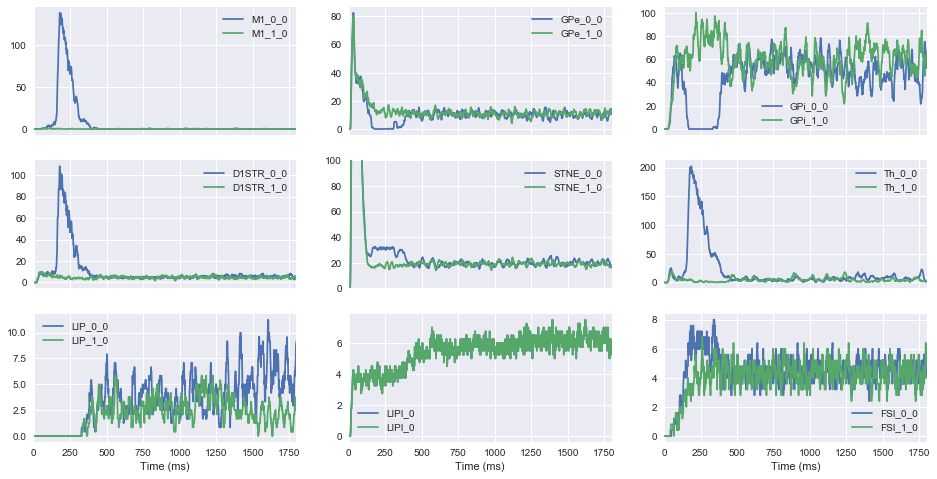

In [76]:
result = results[0][0]

f, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(16,8), sharex=True)
for i in range(0,result['dims']['choices']):
    result['popfreqs'].plot(x='Time (ms)', y='M1_'+str(i)+'_0', ax=ax1[0])
    result['popfreqs'].plot(x='Time (ms)', y='GPe_'+str(i)+'_0', ax=ax1[1])
    result['popfreqs'].plot(x='Time (ms)', y='GPi_'+str(i)+'_0', ax=ax1[2])
    result['popfreqs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax2[0])
    result['popfreqs'].plot(x='Time (ms)', y='STNE_'+str(i)+'_0', ax=ax2[1])
    result['popfreqs'].plot(x='Time (ms)', y='Th_'+str(i)+'_0', ax=ax2[2])
    result['popfreqs'].plot(x='Time (ms)', y='LIP_'+str(i)+'_0', ax=ax3[0])
    result['popfreqs'].plot(x='Time (ms)', y='LIPI_0', ax=ax3[1])
    result['popfreqs'].plot(x='Time (ms)', y='FSI_'+str(i)+'_0', ax=ax3[2])

for ax, axx, axxx in zip(ax1, ax2, ax3):
    ax.set_xlim(0, ax.get_xlim()[-1])
    axx.set_xlim(0, axx.get_xlim()[-1])
    axxx.set_xlim(0, axxx.get_xlim()[-1])

ax2[1].set_ylim(0,100)